In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

import sys
sys.path.append('../')

from utils.results import plot_class_distribution

{0: 'Corn',
 1: 'Cotton',
 2: 'Rice',
 3: 'Sorghum',
 4: 'Sweet Corn',
 5: 'Barley',
 6: 'Durum Wheat',
 7: 'Spring Wheat',
 8: 'Winter Wheat',
 9: 'Rye',
 10: 'Oats',
 11: 'Safflower',
 12: 'Alfalfa',
 13: 'Other Hay/Non Alfalfa',
 14: 'Dry Beans',
 15: 'Other Crops',
 16: 'Watermelons',
 17: 'Onions',
 18: 'Peas',
 19: 'Tomatoes',
 20: 'Sod/Grass Seed',
 21: 'Fallow/Idle Cropland',
 22: 'Cherries',
 23: 'Peaches',
 24: 'Grapes',
 25: 'Other Tree Crops',
 26: 'Citrus',
 27: 'Pecans',
 28: 'Almonds',
 29: 'Walnuts',
 30: 'Pears',
 31: 'Open Water',
 32: 'Developed/Open Space',
 33: 'Developed/Low Intensity',
 34: 'Developed/Med Intensity',
 35: 'Developed/High Intensity',
 36: 'Barren',
 37: 'Deciduous Forest',
 38: 'Evergreen Forest',
 39: 'Shrubland',
 40: 'Grassland/Pasture',
 41: 'Woody Wetlands',
 42: 'Herbaceous Wetlands',
 43: 'Pistachios',
 44: 'Triticale',
 45: 'Carrots',
 46: 'Asparagus',
 47: 'Garlic',
 48: 'Cantaloupes',
 49: 'Olives',
 50: 'Oranges',
 51: 'Honeydew Melons'

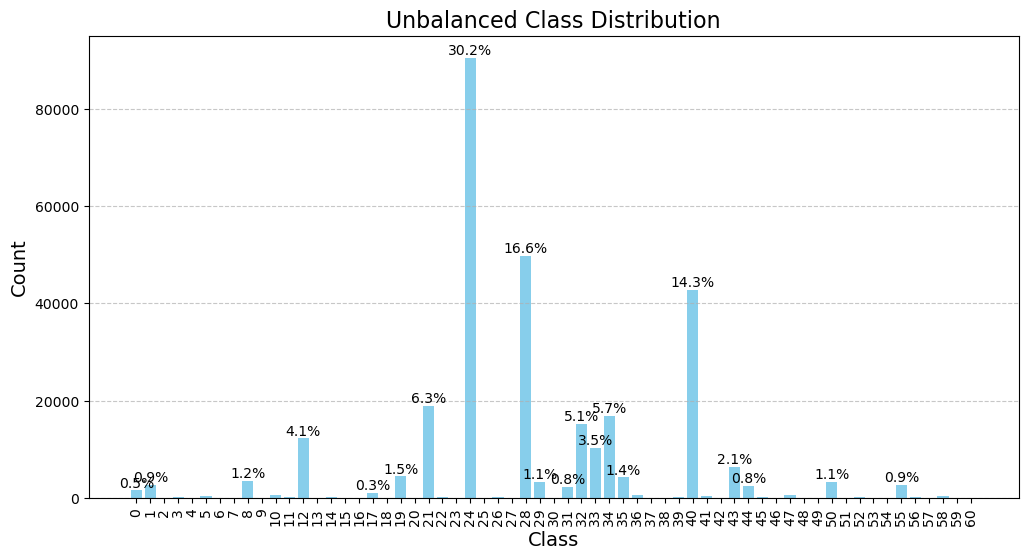

In [2]:
with open('../data/land_cover_representation/metadata.csv') as f:
    metadata = pd.read_csv(f)

classes = pd.unique(metadata['land_cover'])
class_distribution = pd.Series(metadata['land_cover']).value_counts()
classes_dict = pd.Series.to_dict(class_distribution)

class_doc = dict(zip(pd.unique(metadata['y']), pd.unique(metadata['land_cover'])))
class_doc = dict(sorted(class_doc.items()))
display(class_doc)

class_count = {}
for i in range(0, len(class_doc)):
    class_count[i] = (class_doc[i], classes_dict[class_doc[i]])

count_df = pd.DataFrame.from_dict(class_count, orient='index', columns=['land_cover', 'count'])

plot_class_distribution(count_df, title='Unbalanced Class Distribution')

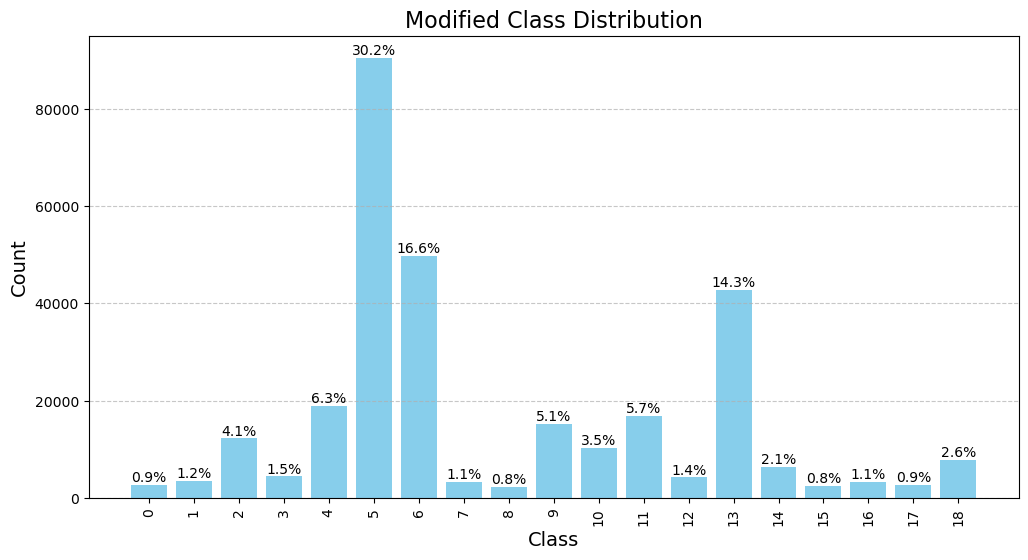

In [3]:
with open('../data/land_cover_representation/metadata_balanced.csv') as f:
    metadata2 = pd.read_csv(f)

classes2 = pd.unique(metadata2['land_cover'])
class_distribution2 = pd.Series(metadata2['land_cover']).value_counts()
classes_dict2 = pd.Series.to_dict(class_distribution2)

class_doc2 = dict(zip(pd.unique(metadata2['y']), pd.unique(metadata2['land_cover'])))
class_doc2 = dict(sorted(class_doc2.items()))

class_count2 = {}
for i in range(0, len(class_doc2)):
    class_count2[i] = (class_doc2[i], classes_dict2[class_doc2[i]])

count_df2 = pd.DataFrame.from_dict(class_count2, orient='index', columns=['land_cover', 'count'])

plot_class_distribution(count_df2, title='Modified Class Distribution')

In [5]:
def group_classes_by_semantics(low_counts_df, high_count_classes, threshold=0.5):
    """
    Groups low-count classes into semantic groups based on similarity to high-count classes.
    """
    # Load a pre-trained model for semantic similarity (e.g., SentenceTransformer)
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate embeddings for high-count class names
    high_count_embeddings = model.encode(high_count_classes, convert_to_tensor=True)

    # Initialize a dictionary for low-count to high-count mappings
    low_to_high_mapping = {}

    for low_class in low_counts_df['land_cover']:
        # Generate embedding for the low-count class
        low_embedding = model.encode(low_class, convert_to_tensor=True)

        # Calculate cosine similarity with high-count classes
        similarities = util.cos_sim(low_embedding, high_count_embeddings).squeeze(0)
        
        # Find the high-count class with the highest similarity above the threshold
        max_sim_idx = similarities.argmax().item()
        if similarities[max_sim_idx] >= threshold:
            low_to_high_mapping[low_class] = high_count_classes[max_sim_idx]
        else:
            # Map to 'Other' if no high similarity is found
            low_to_high_mapping[low_class] = 'Other'

    return low_to_high_mapping

min_count = 2000
similarity_threshold = 0.5

class_distribution = pd.Series(metadata['land_cover']).value_counts()
classes_dict = pd.Series.to_dict(class_distribution)

class_doc = dict(zip(pd.unique(metadata['y']), pd.unique(metadata['land_cover'])))
class_doc = dict(sorted(class_doc.items()))

class_count = {}
for i in range(0, 61):
    class_count[i] = (class_doc[i], classes_dict[class_doc[i]])

count_df = pd.DataFrame.from_dict(class_count, orient='index', columns=['land_cover', 'count'])

low_counts_df = count_df[count_df['count'] < min_count]
high_count_df = count_df[count_df['count'] >= min_count]
high_count_classes = high_count_df['land_cover'].tolist()

low_to_high_mapping = group_classes_by_semantics(low_counts_df, high_count_classes, threshold=similarity_threshold)

display(low_to_high_mapping)

{'Corn': 'Dbl Crop WinWht/Corn',
 'Rice': 'Other',
 'Sorghum': 'Winter Wheat',
 'Sweet Corn': 'Dbl Crop WinWht/Corn',
 'Barley': 'Winter Wheat',
 'Durum Wheat': 'Winter Wheat',
 'Spring Wheat': 'Winter Wheat',
 'Rye': 'Winter Wheat',
 'Oats': 'Other',
 'Safflower': 'Other',
 'Other Hay/Non Alfalfa': 'Alfalfa',
 'Dry Beans': 'Other',
 'Other Crops': 'Dbl Crop WinWht/Corn',
 'Watermelons': 'Tomatoes',
 'Onions': 'Tomatoes',
 'Peas': 'Other',
 'Sod/Grass Seed': 'Other',
 'Cherries': 'Pistachios',
 'Peaches': 'Oranges',
 'Other Tree Crops': 'Dbl Crop WinWht/Corn',
 'Citrus': 'Oranges',
 'Pecans': 'Walnuts',
 'Pears': 'Almonds',
 'Barren': 'Other',
 'Deciduous Forest': 'Other',
 'Evergreen Forest': 'Other',
 'Shrubland': 'Other',
 'Woody Wetlands': 'Other',
 'Herbaceous Wetlands': 'Other',
 'Carrots': 'Tomatoes',
 'Asparagus': 'Other',
 'Garlic': 'Other',
 'Cantaloupes': 'Other',
 'Olives': 'Almonds',
 'Honeydew Melons': 'Other',
 'Pomegranates': 'Other',
 'Nectarines': 'Other',
 'Plums': '